# CS231n in Tensorflow: Assignment 1 q3: Softmax 

This is an exercise of implementing [CS231n assignment 1](http://cs231n.github.io/assignments2016/assignment1/) using [Tensorflow](https://www.tensorflow.org/) instead of doing it by hand in numpy. 

See my [cs231n assignment 1](https://github.com/krosaen/cs231n/tree/master/assignment1) directory for more context and pointers to my solutions to the original assignment; this is an additional exercise I'm doing to make sense of Tensorflow along the way.

## Loading the dataset

(Some of the original code has been modifed to be python3 friendly.)

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [3]:
print(np.max(X_dev[0][:3072] + mean_image))

243.0


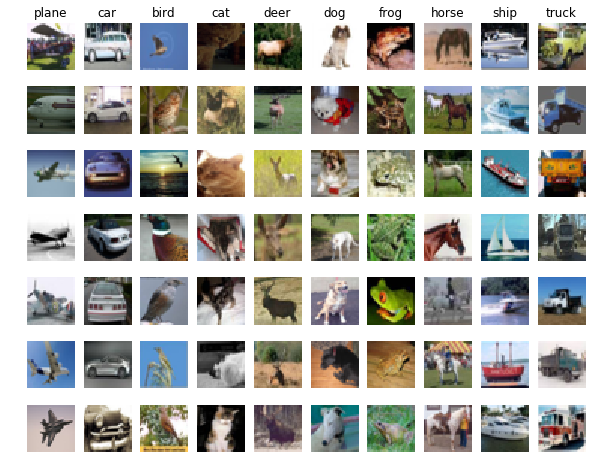

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # note we need to remove bias term and add back the mean image to see 
        # original
        original_image = X_train[idx][:-1] + mean_image
        plt.imshow(original_image.reshape((32, 32, 3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Tensorflow model

I'm basically trying to reproduce what we did in the other notebook, following some of the patterns outlined in the [TF MNIST tutorial](https://www.tensorflow.org/versions/master/get_started/mnist/beginners). I also found some handy tips for e.g setting up tensorboard in [this TF tutorial](https://github.com/tarvaina/tensorflow-tutorial) and within the [TensorBoard summaries docs](https://www.tensorflow.org/get_started/summaries_and_tensorboard). [This tutorial](http://ischlag.github.io/2016/06/04/how-to-use-tensorboard/) also helped.


### Defining the compute graph for training

Note the use of name scopes, which help organize things nicely in TensorBoard.

In [5]:
import tensorflow as tf

def setup_softmax(*, regularization_strength, learning_rate):

    #
    # Define the graph
    #

    tf.reset_default_graph()

    tf_X = tf.placeholder(tf.float32, [None, 3073], name='X') # input images
    tf_y = tf.placeholder(tf.int32, [None], name='y')         # solution labels

    # We are optimizing the weights, so they need to be a variable
    tf_W = tf.Variable(np.random.randn(3073, 10) * 0.001, name='W', dtype=tf.float32)

    # nice to see some original images in tensorboard as a sanity check
    with tf.name_scope("original_image"):
        tf_X_orig = tf.slice(tf_X, [0, 0], [-1, 3072]) + mean_image
        tf_X_reshaped = tf.reshape(tf_X_orig, [-1, 32, 32, 3])
        tf.summary.image('original_image', tf_X_reshaped)

    with tf.name_scope("linear_softmax"):
        scores = tf.matmul(tf_X, tf_W, name='scores')
#         tf.summary.histogram("scores", scores)
    #     with tf.control_dependencies([tf.check_numerics(scores, 'no nans')]):
    #         scores = tf.identity(scores)

        # normalize for numerical stability http://cs231n.github.io/linear-classify/#softmax
        max_scores = tf.reduce_max(scores, reduction_indices=[1], keep_dims=True, name='max_scores')
        scores_stable = tf.subtract(scores, max_scores, name='scores_stable')
        exp_scores = tf.exp(scores_stable)
        exp_scores_sum = tf.reduce_sum(exp_scores, axis=1, keep_dims=True)

    # probability scores per class for each image
    # in root scope so this shows up in top level graph in tensorboard
    p = exp_scores / exp_scores_sum 

    #
    # Define loss compared with solution labels
    #

    with tf.name_scope("cross_entropy_loss"):
        p_correct = tf.gather_nd(
            p,
            tf.transpose(tf.stack([tf.range(tf.shape(tf_y)[0]),
                                   tf_y])),
            name='p_correct')
        loss = tf.reduce_mean(-tf.log(p_correct))

    regularized_loss = loss+ regularization_strength * tf.reduce_sum(tf.square(tf_W))
    tf.summary.scalar('loss', regularized_loss)

    # 
    # Training / accuracy
    #

    with tf.name_scope("train_step"):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(regularized_loss)

    with tf.name_scope("accuracy"):
        predicted_labels =  tf.argmax(p, 1)
        correct_predictions = tf.equal(
            predicted_labels, 
            tf.cast(tf_y, tf.int64), name='correct_predictions')
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', accuracy)
        
    return tf_X, tf_W, tf_y, train_step, accuracy


### Mini-batch training


In [6]:
from time import strftime


def run_training(*, regularization_strength, learning_rate, tf_X, tf_y, train_step, accuracy):
    hparam_str = "lr_{:.0e},reg_{:.0e}".format(learning_rate, regularization_strength)
    print("\nrunning training for {}".format(hparam_str))

    sess = tf.InteractiveSession()
    merged = tf.summary.merge_all()

    time = strftime("%Y-%m-%d_%H:%M")
    train_writer = tf.summary.FileWriter("../logs/softmax_{}_{}_train".format(hparam_str, time), sess.graph)
    validation_writer = tf.summary.FileWriter("../logs/softmax_{}_{}_validation".format(hparam_str, time))

    tf.global_variables_initializer().run()

    for i in range(1500):
        batch_is = np.random.choice(X_train.shape[0], 200, replace=True)
        batch_xs, batch_ys = X_train[batch_is], y_train[batch_is]
        if i % 300 == 0:
            acc, summary = sess.run([accuracy, merged], feed_dict={tf_X: X_val, tf_y: y_val})
            validation_writer.add_summary(summary, i)
            print('Validation accuracy at step {}: {:.3f}'.format(i, acc))
        else:
            _, summary = sess.run([train_step, merged], feed_dict={tf_X: batch_xs, tf_y: batch_ys})
            train_writer.add_summary(summary, i)    

    print('Final test accuracy {}: {:.3f}'.format(
        hparam_str, 
        sess.run([accuracy], feed_dict={tf_X: X_test, tf_y: y_test})[0]))

    return sess


In [7]:
tf_X, tf_W, tf_y, train_step, accuracy = setup_softmax(regularization_strength=5e4, learning_rate=5e-7)
sess = run_training(
    regularization_strength=5e4, learning_rate=5e-7, 
    tf_X=tf_X, tf_y=tf_y, 
    train_step=train_step, accuracy=accuracy)




running training for lr_5e-07,reg_5e+04
Validation accuracy at step 0: 0.100
Validation accuracy at step 300: 0.291
Validation accuracy at step 600: 0.325
Validation accuracy at step 900: 0.305
Validation accuracy at step 1200: 0.320
Final test accuracy lr_5e-07,reg_5e+04: 0.314


## Visualize the learned weights for each class

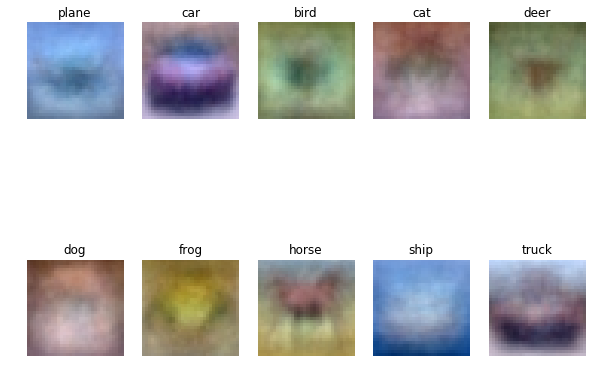

In [8]:
w = sess.run([tf_W])[0][:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

## Hyperparameter tuning

Let's tune the regularization strength and learning rate by logging training runs with different file names, then in TensorBoard, we'll be able to see the difference (and of course we can log it here too).

A nice overview of this approach can be found at [14:05 of this tensorboard talk](https://www.youtube.com/watch?v=eBbEDRsCmv4&feature=youtu.be&t=14m05s).

In [9]:
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        tf_X, tf_W, tf_y, train_step, accuracy = setup_softmax(
            regularization_strength=regularization_strength, learning_rate=learning_rate)
        sess = run_training(
            regularization_strength=regularization_strength, learning_rate=learning_rate, 
            tf_X=tf_X, tf_y=tf_y, 
            train_step=train_step, accuracy=accuracy)



running training for lr_1e-07,reg_5e+04
Validation accuracy at step 0: 0.086
Validation accuracy at step 300: 0.312
Validation accuracy at step 600: 0.315
Validation accuracy at step 900: 0.320
Validation accuracy at step 1200: 0.324
Final test accuracy lr_1e-07,reg_5e+04: 0.318

running training for lr_1e-07,reg_1e+08
Validation accuracy at step 0: 0.117
Validation accuracy at step 300: 0.087
Validation accuracy at step 600: 0.087
Validation accuracy at step 900: 0.087
Validation accuracy at step 1200: 0.087
Final test accuracy lr_1e-07,reg_1e+08: 0.103

running training for lr_5e-07,reg_5e+04
Validation accuracy at step 0: 0.113
Validation accuracy at step 300: 0.314
Validation accuracy at step 600: 0.329
Validation accuracy at step 900: 0.327
Validation accuracy at step 1200: 0.308
Final test accuracy lr_5e-07,reg_5e+04: 0.305

running training for lr_5e-07,reg_1e+08
Validation accuracy at step 0: 0.118
Validation accuracy at step 300: 0.087
Validation accuracy at step 600: 0.087
V

In tensorboard we can see not only the final numbers but e.g how the loss and accuracy changed over time across different parameter settings:

![img](tensorboard-hyperparams.png)